In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os 

GPUID='0'
os.environ['CUDA_VISIBLE_DEVICES']=GPUID

In [3]:
import sys
import datetime
import uuid
from itertools import chain
#export
import time
#pip3 install psutil
import psutil
from exp.nb_formatted import *

In [4]:
device = torch.device(f"cuda:{GPUID}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
torch.cuda.empty_cache()

In [6]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

In [7]:
#set to true on first run
RETRAIN=False
#max mem use for weights in GB in RAM:
MAX_MEM=40

In [8]:
pid = os.getpid()
py = psutil.Process(pid)
memoryUse = py.memory_info()[0] / 2. ** 30
print('memory use:', memoryUse)

memory use: 2.35076904296875


In [9]:
#base, shallow, deep
HOOK_DEPTH = 'shallow'
CURRENT_DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
NAME=HOOK_DEPTH+'_'+CURRENT_DATE+'_'+UID+'_'+GPUID

In [10]:
NAME

'shallow_20190617_7f653558_0'

In [11]:
#keep track of index and layer type
INDEX_DICT={}

In [12]:
cwd=os.getcwd()
IMG_PATH=os.path.abspath(cwd + "/images/")

In [13]:
IMG_PATH

'/mnt/963GB/Data/Python/Courses/my_fastai/2019_pt2_dev_course/dl2/images'

## Serializing the model

Store on ssd rather than in home folder

In [14]:
path = datasets.untar_data(datasets.URLs.IMAGEWOOF_160, dest='data')

In [15]:
size = 128
bs = 64
#bs = 512

tfms = [make_rgb, RandomResizedCrop(size, scale=(0.35,1)), np_to_float, PilRandomFlip()]
val_tfms = [make_rgb, CenterCrop(size), np_to_float]
il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
ll.valid.x.tfms = val_tfms
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=8)

In [16]:
len(il)

12954

In [17]:
loss_func = LabelSmoothingCrossEntropy()
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

Using imagenette norm on imagewoof

In [18]:
learn = cnn_learner(arch=xresnet18, data=data, loss_func=loss_func, opt_func=opt_func, norm=norm_imagenette)

In [19]:
def sched_1cycle(lr, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

In [20]:
lr = 3e-3
pct_start = 0.5
cbsched = sched_1cycle(lr, pct_start)

save out model so can use with pets

1 x 2080ti, bs=256, epochs=10, elapsed: 115.17198395729065

2 x 2080ti, bs=512, epochs=10, elapsed: 79.39946436882019

In [21]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)

In [22]:
#absolute path
HOOK_PATH=mdl_path/NAME
HOOK_PATH.mkdir(exist_ok=True)

In [23]:
if RETRAIN:
    start=time.time()
    learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1, 2])
    learn.fit(500, cbsched)
    end=time.time()
    print(f'elapsed: {end-start}')
    st = learn.model.state_dict()

    print(type(st))

    #keys are names of the layers
    print(', '.join(st.keys()))
    print(path)

    #It's also possible to save the whole model, including the architecture, 
    #but it gets quite fiddly and we don't recommend it. 
    #Instead, just save the parameters, and recreate the model directly.

    #torch.save(st, mdl_path/'iw5')
else:
    print('Loading pre-trained model weights')
    learn.model.load_state_dict(torch.load(mdl_path/'iw5'))
    st = learn.model.state_dict()
    print(st['10.bias'])

Loading pre-trained model weights
tensor([-0.0019,  0.0097, -0.0056, -0.0109,  0.0048,  0.0073, -0.0170, -0.0088,
         0.0120,  0.0037])


## Pets

In [24]:
pets = datasets.untar_data(datasets.URLs.PETS, dest='data')

In [25]:
pets.ls()

[PosixPath('data/oxford-iiit-pet/annotations'),
 PosixPath('data/oxford-iiit-pet/images')]

In [26]:
pets_path = pets/'images'

In [27]:
il = ImageList.from_files(pets_path, tfms=tfms)

In [28]:
il

ImageList (7390 items)
[PosixPath('data/oxford-iiit-pet/images/scottish_terrier_193.jpg'), PosixPath('data/oxford-iiit-pet/images/Bengal_173.jpg'), PosixPath('data/oxford-iiit-pet/images/boxer_147.jpg'), PosixPath('data/oxford-iiit-pet/images/pug_137.jpg'), PosixPath('data/oxford-iiit-pet/images/german_shorthaired_54.jpg'), PosixPath('data/oxford-iiit-pet/images/Ragdoll_88.jpg'), PosixPath('data/oxford-iiit-pet/images/english_setter_120.jpg'), PosixPath('data/oxford-iiit-pet/images/great_pyrenees_120.jpg'), PosixPath('data/oxford-iiit-pet/images/British_Shorthair_212.jpg'), PosixPath('data/oxford-iiit-pet/images/leonberger_155.jpg')...]
Path: data/oxford-iiit-pet/images

We dont have a sapratae validation directory so randomly grab val samples

In [29]:
#export
def random_splitter(fn, p_valid): return random.random() < p_valid

In [30]:
random.seed(42)

In [31]:
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid=0.1))

In [32]:
sd

SplitData
Train: ImageList (6667 items)
[PosixPath('data/oxford-iiit-pet/images/scottish_terrier_193.jpg'), PosixPath('data/oxford-iiit-pet/images/boxer_147.jpg'), PosixPath('data/oxford-iiit-pet/images/pug_137.jpg'), PosixPath('data/oxford-iiit-pet/images/german_shorthaired_54.jpg'), PosixPath('data/oxford-iiit-pet/images/Ragdoll_88.jpg'), PosixPath('data/oxford-iiit-pet/images/english_setter_120.jpg'), PosixPath('data/oxford-iiit-pet/images/British_Shorthair_212.jpg'), PosixPath('data/oxford-iiit-pet/images/chihuahua_132.jpg'), PosixPath('data/oxford-iiit-pet/images/staffordshire_bull_terrier_59.jpg'), PosixPath('data/oxford-iiit-pet/images/chihuahua_127.jpg')...]
Path: data/oxford-iiit-pet/images
Valid: ImageList (723 items)
[PosixPath('data/oxford-iiit-pet/images/Bengal_173.jpg'), PosixPath('data/oxford-iiit-pet/images/great_pyrenees_120.jpg'), PosixPath('data/oxford-iiit-pet/images/leonberger_155.jpg'), PosixPath('data/oxford-iiit-pet/images/Siamese_84.jpg'), PosixPath('data/oxfor

Now need to label - use filenames as cant use folders

In [33]:
n = il.items[0].name; n

'scottish_terrier_193.jpg'

In [34]:
re.findall(r'^(.*)_\d+.jpg$', n)[0]

'scottish_terrier'

In [35]:
def pet_labeler(fn): 
    return re.findall(r'^(.*)_\d+.jpg$', fn.name)[0]

Use CategoryProcessor from last week

In [36]:
proc = CategoryProcessor()

In [37]:
ll = label_by_func(sd, pet_labeler, proc_y=proc)

In [38]:
', '.join(proc.vocab)

'scottish_terrier, boxer, pug, german_shorthaired, Ragdoll, english_setter, British_Shorthair, chihuahua, staffordshire_bull_terrier, Maine_Coon, pomeranian, american_pit_bull_terrier, yorkshire_terrier, Bengal, saint_bernard, Birman, Abyssinian, Bombay, Siamese, keeshond, beagle, american_bulldog, shiba_inu, wheaten_terrier, leonberger, basset_hound, great_pyrenees, japanese_chin, Russian_Blue, Sphynx, havanese, Egyptian_Mau, english_cocker_spaniel, samoyed, newfoundland, miniature_pinscher, Persian'

In [39]:
ll.valid.x.tfms = val_tfms

In [40]:
c_out = len(proc.vocab)

### turn off shuffle 

Dont want shuffling of data at every epoch so can analyze parameter differences across epochs

In [41]:
data = ll.to_databunch(bs, c_in=3, c_out=c_out, num_workers=8, shuffle=False)

In [42]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, norm=norm_imagenette)

In [43]:
if RETRAIN:
    learn.fit(5, cbsched)

<pre>
epoch 	train_loss 	train_accuracy 	valid_loss 	valid_accuracy 	time
0 	3.467661 	0.083246 	3.488343 	0.095436 	00:07
1 	3.303485 	0.126594 	3.571582 	0.112033 	00:07
2 	3.123925 	0.179691 	3.204137 	0.159059 	00:07
3 	2.826835 	0.265037 	2.929686 	0.250346 	00:07
4 	2.544567 	0.360582 	2.638438 	0.355463 	00:07
</pre>

## Custom head

Poor result above, here we read in imagewoof model and customise for pets. Create 10 activations at end.

Also addpend Recorder callback to access loss

In [44]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette, xtra_cb=Recorder)

In [45]:
mdl_path

PosixPath('data/imagewoof-160/models')

In [46]:
st = torch.load(mdl_path/'iw5')

In [47]:
st.keys()

odict_keys(['0.0.weight', '0.1.weight', '0.1.bias', '0.1.running_mean', '0.1.running_var', '0.1.num_batches_tracked', '1.0.weight', '1.1.weight', '1.1.bias', '1.1.running_mean', '1.1.running_var', '1.1.num_batches_tracked', '2.0.weight', '2.1.weight', '2.1.bias', '2.1.running_mean', '2.1.running_var', '2.1.num_batches_tracked', '4.0.convs.0.0.weight', '4.0.convs.0.1.weight', '4.0.convs.0.1.bias', '4.0.convs.0.1.running_mean', '4.0.convs.0.1.running_var', '4.0.convs.0.1.num_batches_tracked', '4.0.convs.1.0.weight', '4.0.convs.1.1.weight', '4.0.convs.1.1.bias', '4.0.convs.1.1.running_mean', '4.0.convs.1.1.running_var', '4.0.convs.1.1.num_batches_tracked', '4.1.convs.0.0.weight', '4.1.convs.0.1.weight', '4.1.convs.0.1.bias', '4.1.convs.0.1.running_mean', '4.1.convs.0.1.running_var', '4.1.convs.0.1.num_batches_tracked', '4.1.convs.1.0.weight', '4.1.convs.1.1.weight', '4.1.convs.1.1.bias', '4.1.convs.1.1.running_mean', '4.1.convs.1.1.running_var', '4.1.convs.1.1.num_batches_tracked', '5.0.c

In [48]:
m = learn.model

In [49]:
mst = m.state_dict()

In [50]:
mst.keys()

odict_keys(['0.0.weight', '0.1.weight', '0.1.bias', '0.1.running_mean', '0.1.running_var', '0.1.num_batches_tracked', '1.0.weight', '1.1.weight', '1.1.bias', '1.1.running_mean', '1.1.running_var', '1.1.num_batches_tracked', '2.0.weight', '2.1.weight', '2.1.bias', '2.1.running_mean', '2.1.running_var', '2.1.num_batches_tracked', '4.0.convs.0.0.weight', '4.0.convs.0.1.weight', '4.0.convs.0.1.bias', '4.0.convs.0.1.running_mean', '4.0.convs.0.1.running_var', '4.0.convs.0.1.num_batches_tracked', '4.0.convs.1.0.weight', '4.0.convs.1.1.weight', '4.0.convs.1.1.bias', '4.0.convs.1.1.running_mean', '4.0.convs.1.1.running_var', '4.0.convs.1.1.num_batches_tracked', '4.1.convs.0.0.weight', '4.1.convs.0.1.weight', '4.1.convs.0.1.bias', '4.1.convs.0.1.running_mean', '4.1.convs.0.1.running_var', '4.1.convs.0.1.num_batches_tracked', '4.1.convs.1.0.weight', '4.1.convs.1.1.weight', '4.1.convs.1.1.bias', '4.1.convs.1.1.running_mean', '4.1.convs.1.1.running_var', '4.1.convs.1.1.num_batches_tracked', '5.0.c

In [51]:
#check that keys are same in both dicts

In [52]:
[k for k in st.keys() if k not in mst.keys()]

[]

In [53]:
m.load_state_dict(st)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [54]:
#want to remove last layer as have different ammount of categries - here 37 pet breeds. Find the AdaptiveAvgPool2d layer and use everything before this

In [55]:
m

XResNet(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [56]:
cut = next(i for i,o in enumerate(m.children()) if isinstance(o,nn.AdaptiveAvgPool2d))
m_cut = m[:cut]

In [57]:
len(m_cut)

8

In [58]:
def module_grandchildren(model):
    grandkids=[]
    for m in m_cut.children():
        for g in m.children():
            grandkids.append(g)
    return grandkids

In [59]:
m_gc = module_grandchildren(m_cut)

In [60]:
xb,yb = get_batch(data.valid_dl, learn)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


In [61]:
pred = m_cut(xb)

In [62]:
pred.shape

torch.Size([128, 512, 4, 4])

To find number of inputs, here we have 128 minibatch of input size 512, 4x4

In [63]:
#number of inputs to our head
ni = pred.shape[1]

Note we use both Avg and Max pool and concatenate them together eg
https://www.cs.cmu.edu/~tzhi/publications/ICIP2016_two_stage.pdf

In [64]:
#export
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=1):
        super().__init__()
        self.output_size = sz
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [65]:
nh = 40

#### weights and stat functions

histc()

Computes the histogram of a tensor.
        
        The elements are sorted into equal width bins between :attr:`min` and
        :attr:`max`. If :attr:`min` and :attr:`max` are both zero, the minimum and
        maximum values of the data are used.

In [66]:
#create a global in the __main__ scope so we can track iterations
stat_iter = 0

In [67]:
#saving weights to disk for later calcs (too much for RAM)
def append_hist_stats(hook, mod, inp, outp):
    '''Note that the hook is a different instance for each layer type
    ie XResNet has its own hook object, AdaptiveConcatPool2d has its own hook object etc
    '''
    if not hasattr(hook,'stats'): 
        hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    if mod.training:
        #eg outp.data shape is [64,512,4,4]
        print(f"{str(mod).split('(')[0]} shape: {outp.data.shape}")
        means.append(outp.data.mean().cpu())
        stds.append(outp.data.std().cpu())
        if isinstance(mod, nn.Linear):
            hists.append(outp.data.cpu().histc(40,-10,10)) #no relu here
        else:
            hists.append(outp.data.cpu().histc(40,0,10)) #no negatives

In [68]:
def write_index_file(data, file_name):
    with open(file_name, 'w') as f:
        print(data, file=f)

In [69]:
#saving weights to disk for later calcs (too much for RAM)
def append_hist_stats_save(hook, mod, inp, outp):
    global stat_iter
    append_hist_stats(hook, mod, inp, outp)
    if mod.training:
        INDEX_DICT[stat_iter]=str(mod).split('(')[0]
        SHAPE_DICT[stat_iter]=str(list(outp.data.size()))
        np.save(f'{HOOK_DATA_PATH}/{stat_iter}.npy', outp.data.cpu())
        stat_iter+=1

In [70]:
#needs work before can use - far too much data to store in RAM without downsampling
def append_raw_hist_stats(hook, mod, inp, outp):
    global stat_iter
    memoryUse=0
    if not hasattr(hook,'stats'): 
        hook.stats = ([],[],[])
    if not hasattr(hook,'raws'): 
        hook.raws = ([])
    means,stds,hists = hook.stats
    raws = hook.raws
    if mod.training:
        #eg outp.data shape is [64,512,4,4]
        means.append(outp.data.mean().cpu())
        stds.append(outp.data.std().cpu())
        if (stat_iter % 100) == 0:
            memoryUse = py.memory_info()[0] / 2. ** 30
        if memoryUse < MAX_MEM:
            d = outp.data
            if len(outp.data.shape)==4:
                new_shape=outp.data.shape
                #want 3 channels so can plot r,g,b
                new_shape[-1]=3
                #put channel as last dimension
                d=d.permute(0, 2, 3, 1)
                d=d.cpu().numpy()
                #calc mean of the whole batch
                d=d.mean(0)
                #now coerce to 3 channels
                d=bin_ndarray(d, new_shape, operation='mean')
            #flatten and linear are dim 2 
            #now take mean over last index to reduce size
            else:
                d=d.cpu().numpy()
            raws.append(d.mean(-1))
            if stat_iter==0:
                print(f'data shape: {outp.data.cpu().numpy().shape}, size: {outp.data.cpu().numpy().size}, mean size: {outp.data.cpu().numpy().mean(-1).size}')
        else:
            print(f'oom appending: {outp.data.cpu().numpy().mean(-1).size}, {outp.data.cpu().numpy().shape}')
        if isinstance(mod, nn.Linear):
            hists.append(outp.data.cpu().histc(40,-10,10)) #no relu here
        else:
            hists.append(outp.data.cpu().histc(40,0,10)) #no negatives
        if stat_iter<100:
            print(f'iter: {stat_iter}, layer: {mod.__class__.__name__}, data shape: {outp.data.cpu().numpy().shape}')
        stat_iter+=1

In [71]:
def read_index_file(model_path, index_file):
    print(f'>>calc_hook_deltas {model_path}/{index_file}')
    data = None
    s = open(f'{model_path}/{index_file}', 'r').read()
    data = eval(s)
    data = collections.OrderedDict(sorted(data.items()))
    return data

In [72]:
def read_hist_stats(file_name):
    array_reloaded = np.load(file_name)
    array_reloaded=torch.from_numpy(array_reloaded).float().to(device)
    return array_reloaded
    

In [73]:
def get_k_by_v(d, val):
    keys = []
    for key, value in d.items():
        if value == val:
            keys.append(key)
    #print(f'val: {val}, len(keys): {len(keys)}')
    return keys 

In [74]:
#see chris albon
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

In [75]:
def calc_hook_epoch_deltas(data_path, index_dict, tot_epochs, model_size):
    '''Differences between weights between epochs for corresponding layers 
    - assumes batches are ordered'''
    #layers of model
    model_layers = [v for v in list(index_dict.values())[:model_size]]

    # for shallow is 525
    runs = int(len(index_dict) / model_size)
    denom = int(runs / tot_epochs)

    epoch_chunks = list(chunks(list(index_dict.keys()), denom))
    first_epoch_data = epoch_chunks[0]

    # block of each full model iteration - want delta between corresponding layers in these
    first_epoch_batches = list(chunks(first_epoch_data, model_size))
    # unpack 2d list to 1d
    first_epoch_batches_list = list(chain.from_iterable(first_epoch_batches))
    first_epoch_batch_indexes = {key: index_dict[key] for key in first_epoch_batches_list if key in index_dict.keys()}

    model_deltas = {}
    i = 0
    model_count = 0
    for key, v in first_epoch_batch_indexes.items():
        # note the step to jump to corresponding layer in next batch
        for offset in range(0, denom*tot_epochs-denom, denom):
            d1 = read_hist_stats(f'{data_path}/{key + offset+ denom-1}.npy')
            d0 = read_hist_stats(f'{data_path}/{key + offset}.npy')
            if d1.size() == d0.size():
                delta = d1 - d0
            else:
                #presumably due to shuffle=on, should not hit here with shuffle=off, TODO test this
                print(f'i: {i}, key: {key}, v: {v} d1.size:{d1.size()}, d0.size:{d0.size()}')

                d1_shp=list(d1.size())
                d0_shp=list(d0.size())
                #total hack, and doesnt really make sense anyway as if sizes are different we 
                #shouldn't be differenceing
                d1_0=int(d1_shp[0])
                d0_0=int(d0_shp[0])
                if len(d1_shp)==4:
                    if d1_0>d0_0:
                        d2 = d1[:int(d0_shp[0]),d1_shp[1]-1,d1_shp[2]-1,d1_shp[3]-1]
                    else:
                        d2 = d0[:d1_shp[0],d0_shp[1]-1,d0_shp[2]-1,d0_shp[3]-1]
                elif len(d1_shp)==3:
                    if d1_0>d0_0:
                        d2 = d1[:d0_shp[0],d1_shp[1]-1,d1_shp[2]-1]
                    else:
                        d2 = d0[:d1_shp[0],d0_shp[1]-1,d0_shp[2]-1]
                elif len(d1_shp)==2:
                    if d1_0>d0_0:
                        d2 = d1[:d0_shp[0],d1_shp[1]-1]
                    else:
                        d2 = d0[:d1_shp[0],d0_shp[1]-1]
                delta = d2
            model_deltas.setdefault(f'{model_count}', []).append(delta)
            model_count += 1
            if model_count >= tot_epochs:
                model_count = 0
            i += 1
    print(f'{i} mem use: {py.memory_info()[0] / 2. ** 30}')
    return model_deltas


In [76]:
def calc_hook_batch_deltas(data_path, index_dict, tot_epochs, epoch, model_size):
    '''Differences between weights between batches for corresponding layers 
    - idicator of data variation between batches
    @Return: dict of key: layer index and value: list of deltas between batches'''
    assert isinstance(tot_epochs, int)
    assert isinstance(epoch, int)

    #for shallow is 525
    runs=int(len(index_dict)/model_size)
    denom=int(runs/tot_epochs)

    epoch_chunks = list(chunks(list(index_dict.keys()), denom))
    epoch_data = epoch_chunks[epoch]
    
    #block of each full model iteration - want delta between corresponding layers in these
    batches=list(chunks(epoch_data, model_size))
    #unpack 2d list to 1d
    batches_list=list(chain.from_iterable(batches))
    batch_indexes= {key: index_dict[key] for key in batches_list if key in index_dict.keys()}
    deltas_dict={}

    deltas=[]
    model_deltas={}
    i=0
    model_count =0
    for key,v in batch_indexes.items():
        #so when get to last batch dont try to read in next one
        if i<len(batch_indexes)-model_size:
            # note the step to jump to corresponding layer in next batch
            d1=read_hist_stats(f'{data_path}/{key+model_size}.npy')
            d0=read_hist_stats(f'{data_path}/{key}.npy')
            if d1.size() == d0.size():
                delta = d1-d0
            else:
                print(f'i: {i}, key: {key}, v: {v} d1.size:{d1.size()}, d0.size:{d0.size()}')
            model_deltas.setdefault(model_count, []).append(delta)
            model_count+=1
            if model_count>=model_size:
                model_count=0
            i+=1
    return model_deltas

In [77]:
#get the hist data at index 2
def get_hist(h): 
    assert len(h.stats)==3
    return torch.stack(h.stats[2]).t().float().log1p().cpu()

In [78]:
def get_delta_hist(h): 
    return torch.stack(h.hdeltas).t().float().log1p().cpu()

In [79]:
def diff_stats(hooks_data):
    histsl=[]
    msl=[]
    ssl=[]
    for h in hooks_data:
        histsl.append(get_hist(h))
        ms,ss, hists = h.stats
        msl.append(ms)
        ssl.append(ss)
    del_ms=np.diff(msl)
    del_ss=np.diff(ssl)
    return del_ms,del_ss

In [80]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [81]:
def get_start_mins(h):
    h1 = torch.stack(h.stats[2]).t().float().cpu()
    return h1[:2].sum(0)/h1.sum(0)

In [82]:
def get_mid_mins(h, max_hist):
    h1 = torch.stack(h.stats[2]).t().float().cpu()
    #get stats on middle bins of histogram data
    return h1[int((max_hist/2)-1):int((max_hist/2)+2)].sum(0)/h1.sum(0)

#### plotting

In [83]:
def plot_hooks(hooks, model, fig_name=None):
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    print(f'plotting {len(hooks)} layers')
    i=0
    first_len=0
    for h,m in zip(hooks,model):
        ms,ss, hists = h.stats
        if i==0:
            first_len=len(ms)
        #print(f"{i}, {str(m).split('(')[0]}: {len(ms)}")
        if str(m).split('(')[0]=='ReLU':
        #data for Relu layer is 19 times longer than other layers, not sure why
            ms=ms[:first_len] 
            ss=ss[:first_len] 
        ax0.plot(ms)
        ax0.set_title('mean')
        ax1.plot(ss)
        ax1.set_title('std. dev.')
        i+=1
    if model:   
        titles=[]
        idxs=[]
        for j,m in enumerate(learn.model):
            titles.append(str(j)+' '+str(m).split('(')[0])
        plt.legend(titles)
    else:
        plt.legend(range(len(hooks)))
    if fig_name:
        plt.savefig(IMG_PATH+'/'+NAME+'_'+fig_name)
    plt.show()

In [84]:
def plot_deltas(deltas, smoother, fig_name=None):
    half_plots=int((len(deltas)/2) + (len(deltas)/2 % 1 > 0))
    fig,axes= plt.subplots(half_plots,2, figsize=(10,half_plots*2))
    for ax,h in zip(axes.flatten(), deltas):
        h = smooth(h, smoother)
        ax.plot(h)
        ax.set_title('delta')
    plt.legend(range(len(deltas)))
    if fig_name:
        plt.savefig(IMG_PATH+'/'+NAME+'_'+fig_name)
    plt.show()

In [85]:
def plot_hooks_hist(hooks, fig_name=None, model=None):
    #subplots(rows,colums)
    half_plots=int((len(hooks)/2) + (len(hooks)/2 % 1 > 0))
    fig,axes = plt.subplots(half_plots,2, figsize=(15,int(len(hooks)/2)*3))
    i=0
    for ax,h in zip(axes.flatten(), hooks):
        ax.imshow(get_hist(h), origin='lower')
        ax.imshow(get_hist(h))
        ax.set_aspect('auto')
        ax.axis('on')
        if model:
            for j,m in enumerate(learn.model):
                if i == j:
                    title=str(m).split('(')[0]
                    ax.set_title(title)
        i+=1
    plt.tight_layout()
    if fig_name:
        plt.savefig(IMG_PATH+'/'+NAME+'_'+fig_name)
    plt.show()

In [86]:
def plot_hooks_delta_hist(hooks, fig_name=None,model=None):
    #subplots(rows,colums)
    half_plots=int((len(hooks)/2) + (len(hooks)/2 % 1 > 0))
    fig,axes = plt.subplots(half_plots,2, figsize=(15,int(len(hooks)/2)*3))
    i=0
    for ax,h in zip(axes.flatten(), hooks):
        ax.imshow(get_delta_hist(h), origin='lower')
        ax.imshow(get_delta_hist(h))
        ax.set_aspect('auto')
        ax.axis('on')
        if model:
            for j,m in enumerate(learn.model):
                if i == j:
                    title=str(m).split('(')[0]
                    ax.set_title(title)
        i+=1
    plt.tight_layout()
    if fig_name:
        plt.savefig(IMG_PATH+'/'+NAME+'_'+fig_name)
    plt.show()

In [87]:
def plot_hooks_hist_lines(hooks, fig_name=None):
    half_plots=int((len(hooks)/2) + (len(hooks)/2 % 1 > 0))
    fig,axes = plt.subplots(half_plots,2, figsize=(15,int(len(hooks)/2)*5))
    for ax,h in zip(axes.flatten(), hooks):
        ax.plot(get_hist(h))
        ax.axis('on')
    if fig_name:
        plt.savefig(IMG_PATH+'/'+NAME+'_'+fig_name)
    plt.show()

In [88]:
def plot_mins(hooks):
    half_plots=int((len(hooks)/2) + (len(hooks)/2 % 1 > 0))
    fig,axes = plt.subplots(half_plots,2, figsize=(15,int(len(hooks)/2)*2))
    for ax,h in zip(axes.flatten(), hooks):
        ax.plot(get_start_mins(h))
        ax.set_ylim(0,1)
        ax.axis('on')
    plt.tight_layout()
    plt.legend(['start'])

In [89]:
def plot_mid_mins(hooks):
    half_plots=int((len(hooks)/2) + (len(hooks)/2 % 1 > 0))
    fig,axes = plt.subplots(half_plots,2, figsize=(15,int(len(hooks)/2)*2))
    hist = get_hist(hooks[0])
    max_hist=hist.shape[0]
    print(max_hist)
    for ax,h in zip(axes.flatten(), hooks):
        ax.plot(get_mid_mins(h,max_hist))
        ax.set_ylim(-1,1)
        ax.axis('on')
    plt.tight_layout()
    plt.legend(['mid'])

In [90]:
def plot_ep_vals(ep_vals, fig_name=None):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = ep_vals.keys()
    plt.xticks(np.asarray(list(epochs)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    val_losses = [item[1] for item in list(ep_vals.values())]
    plt.plot(epochs, trn_losses, c='b', label='train')
    plt.plot(epochs, val_losses, c='r', label='validation')
    plt.legend(loc='upper left')
    if fig_name:
        plt.savefig(IMG_PATH+'/'+NAME+'_'+fig_name)
    plt.show()

In [91]:
def plot_raw_layers(hooks):
    for h in hooks:
        print(len(h.raws))
        h_raw_np=np.concatenate(h.raws, axis=0 )
        plot_kernels(h_raw_np)

In [92]:
#after Fchaubard https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/7
def plot_kernels(tensor, num_cols=6):
    if isinstance(tensor, list):
        print(len(tensor))
        print(tensor[0].shape)
    if not tensor.ndim==4:
        #not plotting Flatten or Linear layers
        return
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [93]:
for i,m in enumerate(learn.model):
    print(f'i: {i}, model part: {m}')

i: 0, model part: Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
)
i: 1, model part: Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
)
i: 2, model part: Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
)
i: 3, model part: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
i: 4, model part: Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

## Naive Model 

Allow hook to access internals of XResNet by unpacking arg list

In [94]:
m_new = nn.Sequential(
    *m_cut.children(), AdaptiveConcatPool2d(), Flatten(),
    nn.Linear(ni*2, data.c_out))

In [95]:
m_new_deep = nn.Sequential(
    *m_gc, AdaptiveConcatPool2d(), Flatten(),
    nn.Linear(ni*2, data.c_out))

In [96]:
m_new_shallow = nn.Sequential(
    m_cut, AdaptiveConcatPool2d(), Flatten(),
    nn.Linear(ni*2, data.c_out))

In [97]:
if HOOK_DEPTH=='deep':
    learn.model = m_new_deep
elif HOOK_DEPTH=='base':
    learn.model = m_new
elif HOOK_DEPTH=='shallow':
    learn.model = m_new_shallow

In [98]:
len(learn.model)

4

When we ran telemetry previously in lesson 10 (nb 06), were were using a manually built model with 7 layers:

<pre>
    Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)
</pre>

Like the code below the AdaptiveAvgPool2d and Lambda (below we use Flatten) have the same output data-ie same plot

### Fit

[batch_size, channels, height, width]

In [99]:
stat_iter = 0

In [100]:
INDEX_DICT={}
SHAPE_DICT={}
HOOK_DATA_PATH = HOOK_PATH/'naive'
HOOK_DATA_PATH.mkdir(exist_ok=True)

In [101]:
#5
with Hooks(learn.model, append_hist_stats_save) as hooks_naive: 
    learn.fit(5, cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.843827,0.284236,2.430064,0.374827,00:08
1,2.177454,0.458077,2.572732,0.380360,00:08
2,1.998479,0.534573,2.229394,0.474412,00:08
3,1.722406,0.641518,1.822197,0.578147,00:08
4,1.455752,0.752962,1.590648,0.681881,00:08


XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024

XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024

XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024

Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2

XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024

Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])


XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024

XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024

Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2

XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024

XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024])
Linear shape: torch.Size([64, 37])
XResNet shape: torch.Size([64, 512, 4, 4])
AdaptiveConcatPool2d shape: torch.Size([64, 1024, 1, 1])
Flatten shape: torch.Size([64, 1024

In [102]:
write_index_file(data=INDEX_DICT, file_name=HOOK_DATA_PATH/'index.txt')
write_index_file(data=SHAPE_DICT, file_name=HOOK_DATA_PATH/'shape.txt')
print(f"wrote {len(INDEX_DICT)} items to : {HOOK_DATA_PATH/'index.txt'}")

wrote 2100 items to : data/imagewoof-160/models/shallow_20190617_7f653558_0/naive/index.txt


<pre>
epoch 	train_loss 	train_accuracy 	valid_loss 	valid_accuracy 	time
0 	2.852017 	0.287686 	2.486142 	0.387275 	00:08
1 	2.179299 	0.469177 	2.641399 	0.352697 	00:07
2 	2.030308 	0.531273 	2.449481 	0.413555 	00:07
3 	1.731837 	0.638368 	1.788130 	0.615491 	00:07
4 	1.465440 	0.747413 	1.599652 	0.690180 	00:07
</pre>

In [103]:
#temp for testing only
#HOOK_DATA_PATH=HOOK_PATH/'naive'

In [104]:
index_dict=read_index_file(HOOK_DATA_PATH.absolute(), 'index.txt')

>>calc_hook_deltas /mnt/963GB/Data/Python/Courses/my_fastai/2019_pt2_dev_course/dl2/data/imagewoof-160/models/shallow_20190617_7f653558_0/naive/index.txt


In [105]:
model_layers = [v for v in list(index_dict.values())[:len(learn.model)]]
model_layers

['XResNet', 'AdaptiveConcatPool2d', 'Flatten', 'Linear']

In [106]:
batch_deltas=calc_hook_batch_deltas(HOOK_DATA_PATH.absolute(), index_dict, tot_epochs=5,epoch=0, model_size=len(learn.model))

In [107]:
len(batch_deltas)

4

In [108]:
len(batch_deltas[0])

26

In [109]:
epoch_deltas=calc_hook_epoch_deltas(HOOK_DATA_PATH.absolute(), index_dict, tot_epochs=5, model_size=len(learn.model))

i: 3, key: 0, v: XResNet d1.size:torch.Size([11, 37]), d0.size:torch.Size([64, 37])
i: 407, key: 101, v: AdaptiveConcatPool2d d1.size:torch.Size([64, 512, 4, 4]), d0.size:torch.Size([11, 512, 4, 4])
i: 410, key: 102, v: Flatten d1.size:torch.Size([11, 512, 4, 4]), d0.size:torch.Size([64, 512, 4, 4])
i: 411, key: 102, v: Flatten d1.size:torch.Size([64, 1024, 1, 1]), d0.size:torch.Size([11, 1024, 1, 1])
i: 414, key: 103, v: Linear d1.size:torch.Size([11, 1024, 1, 1]), d0.size:torch.Size([64, 1024, 1, 1])
i: 415, key: 103, v: Linear d1.size:torch.Size([64, 1024]), d0.size:torch.Size([11, 1024])
i: 418, key: 104, v: XResNet d1.size:torch.Size([11, 1024]), d0.size:torch.Size([64, 1024])
i: 419, key: 104, v: XResNet d1.size:torch.Size([64, 37]), d0.size:torch.Size([11, 37])
420 mem use: 2.695629119873047


In [110]:
len(epoch_deltas)

5

In [117]:
len(epoch_deltas[list(epoch_deltas.keys())[0]])

84

##### Plots

plotting 4 layers


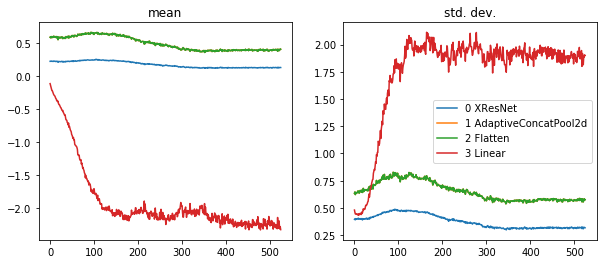

In [97]:
plot_hooks(hooks_naive,fig_name='naive_stats.png',model=learn.model)

In [98]:
type(hooks_naive)

exp.nb_formatted.Hooks

#### Histograms

In [243]:
len(hooks_naive)

4

In [250]:
ms,ss, hists = hooks_naive[0].stats
len(hists); 

525

In [252]:
hists[0].shape

torch.Size([40])

In [254]:
ms[0]

tensor(0.2226)

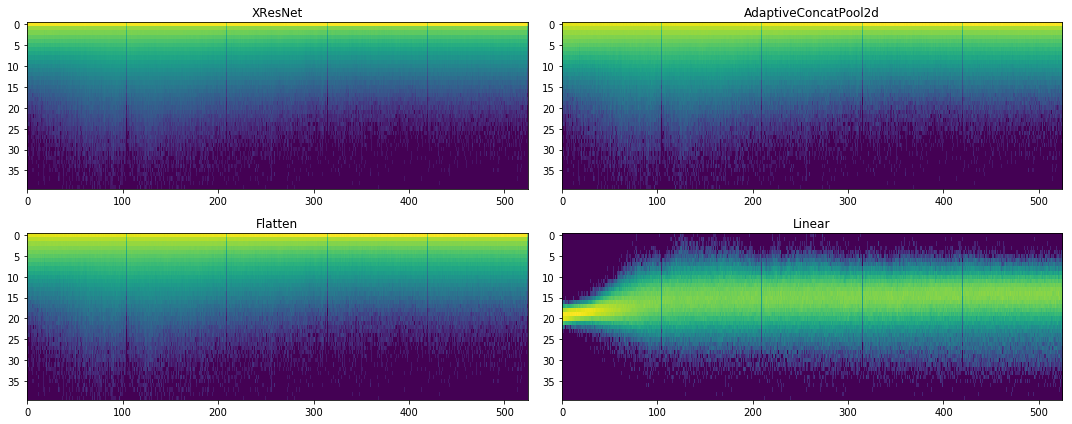

In [100]:
plot_hooks_hist(hooks_naive,fig_name='naive_hists.png',model=learn.model)

In [101]:
#plot_mid_mins(hooks_naive)

In [102]:
naive_del_ms,naive_del_ss=diff_stats(hooks_naive)

Means change between each layer

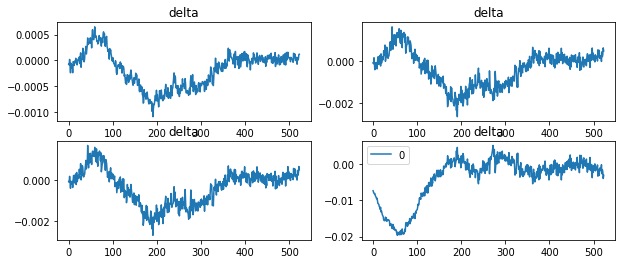

In [103]:
plot_deltas(naive_del_ms, 50,fig_name='naive_del_ms.png')

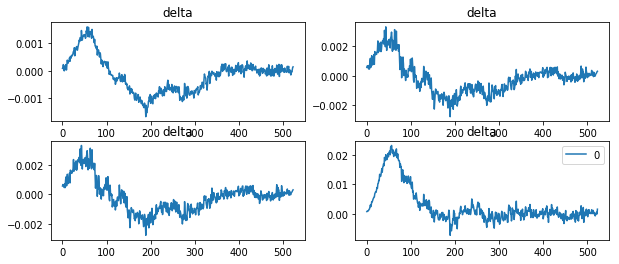

In [104]:
plot_deltas(naive_del_ss, 50,fig_name='naive_del_sds.png')

Means change between first and last layer

2
2


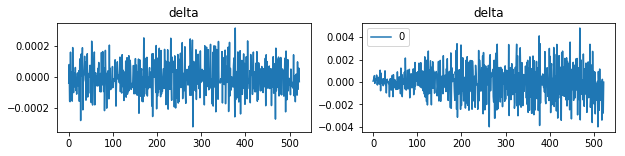

In [105]:
first_n_last = [naive_del_ms[0], naive_del_ms[-1]]
print(len(first_n_last))
naive_del_fal=np.diff(first_n_last)
print(len(naive_del_fal))
plot_deltas(naive_del_fal, 50)

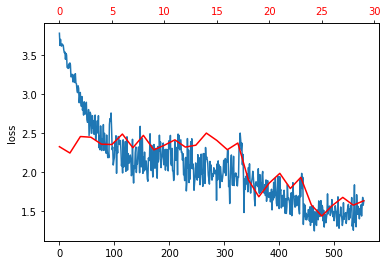

In [106]:
learn.recorder.plot_loss()

In [107]:
len(learn.recorder.losses)/len(learn.recorder.val_losses)

18.5

In [108]:
#18.5 * more training data than validation data 

In [109]:
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('INDEX_DICT', 73824),
 ('mst', 11104),
 ('st', 11104),
 ('naive_del_ms', 8496),
 ('naive_del_ss', 8496),
 ('naive_del_fal', 4296),
 ('image_extensions', 2272),
 ('AdaptiveConcatPool2d', 1464),
 ('DataLoader', 1464),
 ('LabelSmoothingCrossEntropy', 1464),
 ('ResBlock', 1464),
 ('master_bar', 1464),
 ('Flatten', 1184),
 ('XResNet', 1184),
 ('AWD_LSTM', 1056),
 ('AverageGrad', 1056),
 ('AverageSqrGrad', 1056),
 ('AvgStats', 1056),
 ('AvgStatsCallback', 1056),
 ('BatchTransformXCallback', 1056),
 ('Beta', 1056),
 ('Callback', 1056),
 ('CancelBatchException', 1056),
 ('CancelEpochException', 1056),
 ('CancelTrainException', 1056),
 ('CategoryProcessor', 1056),
 ('CenterCrop', 1056),
 ('CudaCallback', 1056),
 ('DataBunch', 1056),
 ('Dataset', 1056),
 ('DebugCallback', 1056),
 ('EmbeddingDropout', 1056),
 ('GeneralCrop', 1056),
 ('GeneralRelu', 1056),
 ('GradientClipping', 1056),
 ('Hook', 1056),
 ('Hooks', 1056),
 ('ImageList', 1056),
 ('ItemList', 1056),
 ('Javascript', 1056),
 ('LM_PreLo

In [110]:
#clear mem
naive_del_ms=None
naive_del_ss=None
hooks_naive=None
naive_del_fal=None

## adapt_model and gradual unfreezing

Lines above pasted into one cell to create a function (Shift-M)

In [111]:
def adapt_model(learn, data):
    cut = next(i for i,o in enumerate(learn.model.children())
               if isinstance(o,nn.AdaptiveAvgPool2d))
    m_cut = learn.model[:cut]
    xb,yb = get_batch(data.valid_dl, learn)
    pred = m_cut(xb)
    ni = pred.shape[1]
    m_new = nn.Sequential(
        #replace m_cut with children to get data for each layer in XResNet
        *m_cut.children(), AdaptiveConcatPool2d(), Flatten(),
        nn.Linear(ni*2, data.c_out))
    learn.model = m_new

In [112]:
def adapt_deep_model(learn, data):
    cut = next(i for i,o in enumerate(learn.model.children())
               if isinstance(o,nn.AdaptiveAvgPool2d))
    m_cut = learn.model[:cut]
    m_gc = module_grandchildren(m_cut)
    xb,yb = get_batch(data.valid_dl, learn)
    pred = m_cut(xb)
    ni = pred.shape[1]
    m_new = nn.Sequential(
        #replace m_cut with grandchildren to get data for each layer in XResNet
        *m_gc, AdaptiveConcatPool2d(), Flatten(),
        nn.Linear(ni*2, data.c_out))
    learn.model = m_new

In [113]:
def adapt_simple_model(learn, data):
    cut = next(i for i,o in enumerate(learn.model.children())
               if isinstance(o,nn.AdaptiveAvgPool2d))
    m_cut = learn.model[:cut]
    xb,yb = get_batch(data.valid_dl, learn)
    pred = m_cut(xb)
    ni = pred.shape[1]
    m_new = nn.Sequential(
        m_cut, AdaptiveConcatPool2d(), Flatten(),
        nn.Linear(ni*2, data.c_out))
    learn.model = m_new

In [114]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette, xtra_cb=Recorder)
learn.model.load_state_dict(torch.load(mdl_path/'iw5'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [115]:
if HOOK_DEPTH=='deep':
    adapt_deep_model(learn, data)
elif HOOK_DEPTH=='base':
    adapt_model(learn, data)
elif HOOK_DEPTH=='shallow':
    adapt_simple_model(learn, data)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


basic model as per lesson len: 4, with children len: 11, with grandchildren len: 20

In [116]:
len(learn.model); HOOK_DEPTH

'shallow'

Grab all parameters in the body (the m_cut bit) and dont train these - just train the head

In [117]:
INDEX_DICT={}
SHAPE_DICT={}
HOOK_DATA_PATH = HOOK_PATH/'freeze'
HOOK_DATA_PATH.mkdir(exist_ok=True)

In [118]:
#reset
stat_iter=0

#### Freeze everything before head

In [119]:
#everything before AdaptiveConcatPool2d 
for i in range(len(learn.model)-3):
    for p in learn.model[0].parameters(): p.requires_grad_(False)

In [120]:
with Hooks(learn.model, append_hist_stats_save) as hooks_freeze: 
    learn.fit(3, sched_1cycle(1e-2, 0.5))

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.863242,0.278386,2.751835,0.388658,00:06
1,2.877852,0.356982,2.767974,0.398340,00:06
2,2.238520,0.489726,2.133225,0.517289,00:06


In [121]:
write_index_file(data=INDEX_DICT, file_name=HOOK_DATA_PATH/'index.txt')
write_index_file(data=SHAPE_DICT, file_name=HOOK_DATA_PATH/'shape.txt')
print(f"wrote {len(INDEX_DICT)} items to : {HOOK_DATA_PATH/'index.txt'}")

wrote 1260 items to : data/imagewoof-160/models/shallow_20190616_d13f5c2a_0/freeze/index.txt


plotting 4 layers


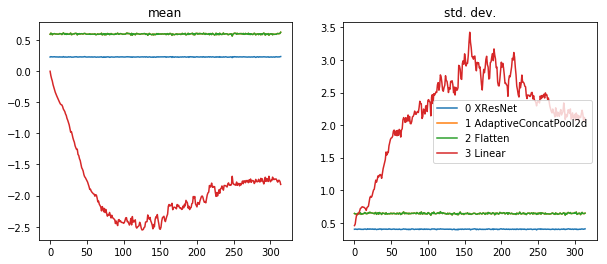

In [122]:
plot_hooks(hooks_freeze,fig_name='freeze_layer_stats.png',model=learn.model)

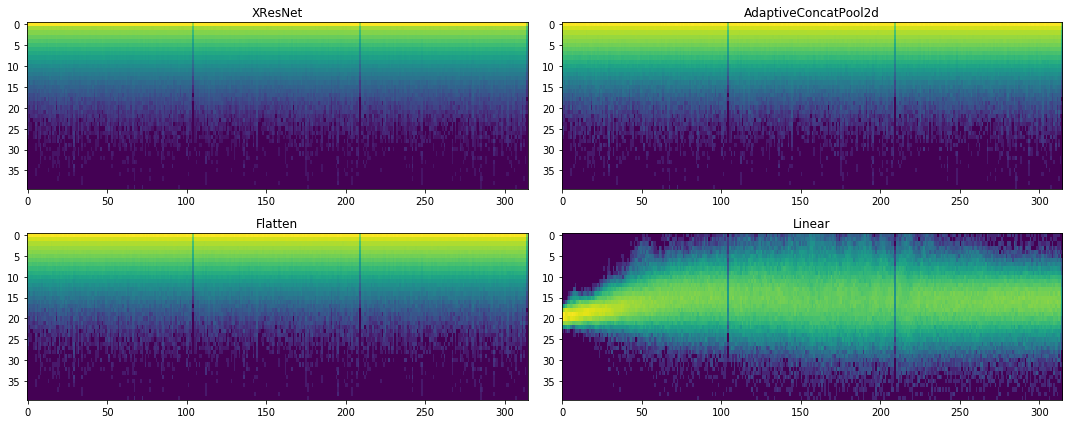

In [123]:
plot_hooks_hist(hooks_freeze,fig_name='freeze_hists.png',model=learn.model)

In [124]:
#plot_hooks_delta_hist(hooks_freeze,fig_name='freeze_delta_hists.png',model=learn.model)

In [125]:
#plot_mid_mins(hooks_freeze)

In [126]:
frozen_del_ms,frozen_del_ss=diff_stats(hooks_freeze)

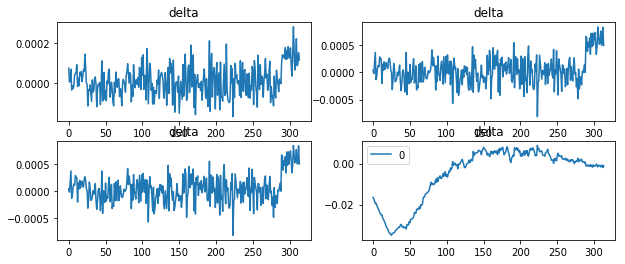

In [127]:
plot_deltas(frozen_del_ms, 50,fig_name='freeze_del_ms.png')

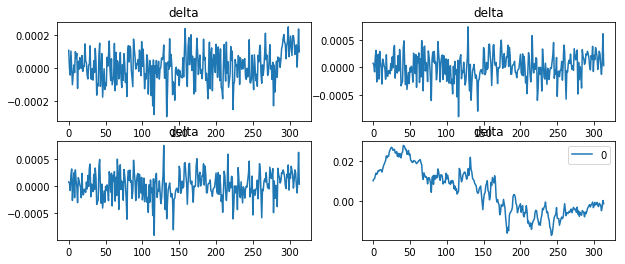

In [128]:
plot_deltas(frozen_del_ss, 50,fig_name='freeze_del_sds.png')

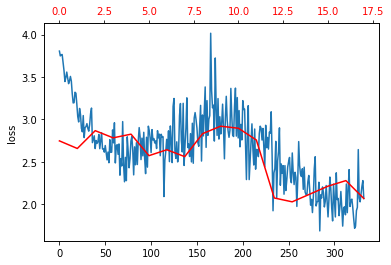

In [129]:
learn.recorder.plot_loss()

In [130]:
#clear mem
frozen_del_ms=None
frozen_del_ss=None
hooks_freeze=None

In [131]:
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('INDEX_DICT', 36968),
 ('mst', 11104),
 ('st', 11104),
 ('image_extensions', 2272),
 ('AdaptiveConcatPool2d', 1464),
 ('DataLoader', 1464),
 ('LabelSmoothingCrossEntropy', 1464),
 ('ResBlock', 1464),
 ('master_bar', 1464),
 ('Flatten', 1184),
 ('XResNet', 1184),
 ('AWD_LSTM', 1056),
 ('AverageGrad', 1056),
 ('AverageSqrGrad', 1056),
 ('AvgStats', 1056),
 ('AvgStatsCallback', 1056),
 ('BatchTransformXCallback', 1056),
 ('Beta', 1056),
 ('Callback', 1056),
 ('CancelBatchException', 1056),
 ('CancelEpochException', 1056),
 ('CancelTrainException', 1056),
 ('CategoryProcessor', 1056),
 ('CenterCrop', 1056),
 ('CudaCallback', 1056),
 ('DataBunch', 1056),
 ('Dataset', 1056),
 ('DebugCallback', 1056),
 ('EmbeddingDropout', 1056),
 ('GeneralCrop', 1056),
 ('GeneralRelu', 1056),
 ('GradientClipping', 1056),
 ('Hook', 1056),
 ('Hooks', 1056),
 ('ImageList', 1056),
 ('ItemList', 1056),
 ('Javascript', 1056),
 ('LM_PreLoader', 1056),
 ('LR_Find', 1056),
 ('LabeledData', 1056),
 ('Lambda', 1056),

#### Unfreeze

In [132]:
#reset
stat_iter=0

In [133]:
INDEX_DICT={}
SHAPE_DICT={}
HOOK_DATA_PATH = HOOK_PATH/'unfreeze'
HOOK_DATA_PATH.mkdir(exist_ok=True)

In [134]:
#everything before AdaptiveConcatPool2d - note difference to lesson nb where just have layer 0
for i in range(len(learn.model)-3):
    for p in learn.model[i].parameters(): p.requires_grad_(True)

In [135]:
with Hooks(learn.model, append_hist_stats_save) as hooks_unfreeze: 
    learn.fit(5, cbsched, reset_opt=True)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.941628,0.568172,2.159941,0.497925,00:08
1,1.985888,0.545973,2.422953,0.424620,00:08
2,1.933837,0.564572,2.361913,0.453665,00:08
3,1.692772,0.655317,1.773183,0.623790,00:08
4,1.437745,0.760762,1.594461,0.702628,00:08


In [136]:
write_index_file(data=INDEX_DICT, file_name=HOOK_DATA_PATH/'index.txt')
write_index_file(data=SHAPE_DICT, file_name=HOOK_DATA_PATH/'shape.txt')
print(f"wrote {len(INDEX_DICT)} items to : {HOOK_DATA_PATH/'index.txt'}")

wrote 2100 items to : data/imagewoof-160/models/shallow_20190616_d13f5c2a_0/unfreeze/index.txt



In frozen layer - train for particuar mean and std dev, but pets has different std dev and means inside the model.

What is really going on here? (1:26 in lesson video), and why do I get better results when JH got worse result?

plotting 4 layers


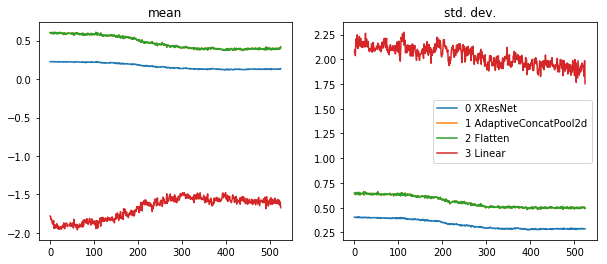

In [137]:
plot_hooks(hooks_unfreeze,fig_name='unfreeze_layer_stats.png',model=learn.model)

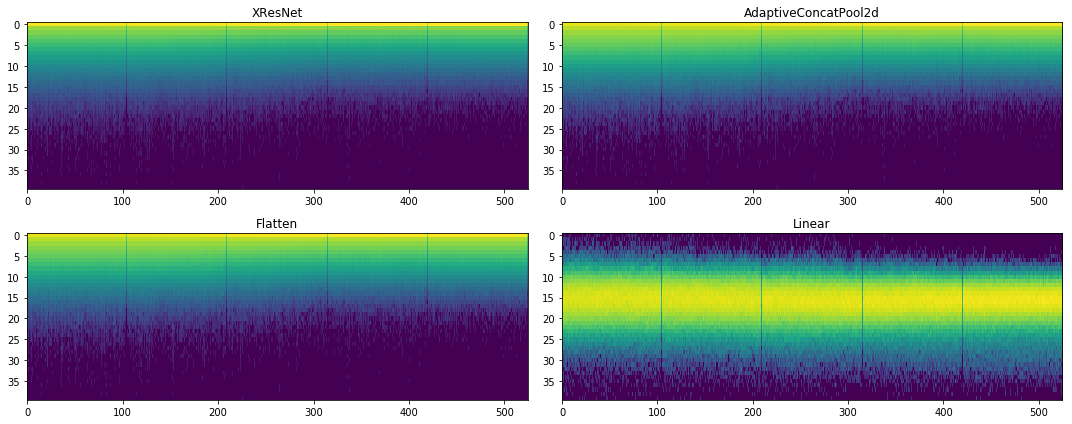

In [138]:
plot_hooks_hist(hooks_unfreeze,fig_name='unfreeze_hists.png',model=learn.model)

In [139]:
#plot_hooks_delta_hist(hooks_unfreeze,fig_name='unfreeze_delta_hists.png',model=learn.model)

In [140]:
#plot_mid_mins(hooks_unfreeze)

In [141]:
unfrozen_del_ms,unfrozen_del_ss=diff_stats(hooks_unfreeze)

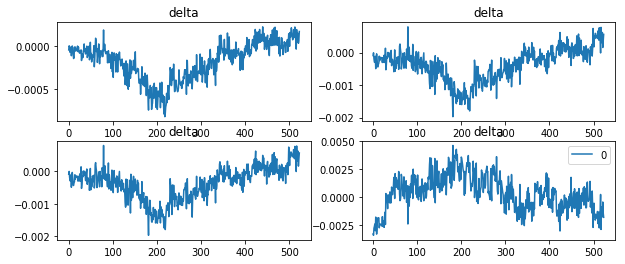

In [142]:
plot_deltas(unfrozen_del_ms, 50,fig_name='unfreeze_del_ms.png')

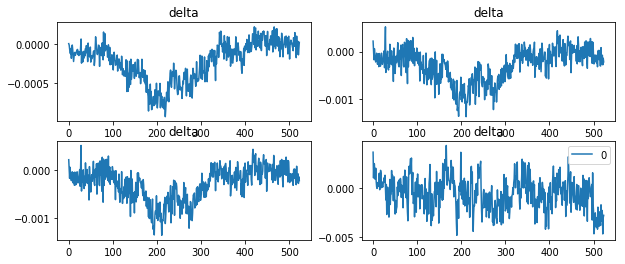

In [143]:
plot_deltas(unfrozen_del_ss, 50,fig_name='unfreeze_del_sds.png')

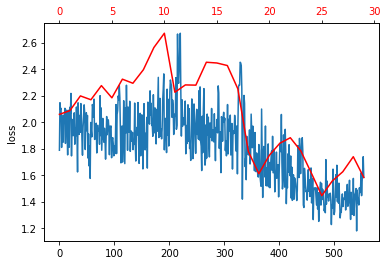

In [144]:
learn.recorder.plot_loss()

Freeze only layer params that aren't in the batch norm layers

1:27 in lesson 12

In [145]:
#clear mem
unfrozen_del_ms=None
unfrozen_del_ss=None
hooks_unfreeze=None

In [146]:
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('INDEX_DICT', 73824),
 ('mst', 11104),
 ('st', 11104),
 ('image_extensions', 2272),
 ('AdaptiveConcatPool2d', 1464),
 ('DataLoader', 1464),
 ('LabelSmoothingCrossEntropy', 1464),
 ('ResBlock', 1464),
 ('master_bar', 1464),
 ('Flatten', 1184),
 ('XResNet', 1184),
 ('AWD_LSTM', 1056),
 ('AverageGrad', 1056),
 ('AverageSqrGrad', 1056),
 ('AvgStats', 1056),
 ('AvgStatsCallback', 1056),
 ('BatchTransformXCallback', 1056),
 ('Beta', 1056),
 ('Callback', 1056),
 ('CancelBatchException', 1056),
 ('CancelEpochException', 1056),
 ('CancelTrainException', 1056),
 ('CategoryProcessor', 1056),
 ('CenterCrop', 1056),
 ('CudaCallback', 1056),
 ('DataBunch', 1056),
 ('Dataset', 1056),
 ('DebugCallback', 1056),
 ('EmbeddingDropout', 1056),
 ('GeneralCrop', 1056),
 ('GeneralRelu', 1056),
 ('GradientClipping', 1056),
 ('Hook', 1056),
 ('Hooks', 1056),
 ('ImageList', 1056),
 ('ItemList', 1056),
 ('Javascript', 1056),
 ('LM_PreLoader', 1056),
 ('LR_Find', 1056),
 ('LabeledData', 1056),
 ('Lambda', 1056),

## Batch norm transfer

Freeze all params that are not in the batchnorm layer or linear layer at end

In [147]:
#reset
stat_iter=0

In [148]:
INDEX_DICT={}
SHAPE_DICT={}
HOOK_DATA_PATH = HOOK_PATH/'bn_freeze'
HOOK_DATA_PATH.mkdir(exist_ok=True)

In [149]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette, xtra_cb=Recorder)
learn.model.load_state_dict(torch.load(mdl_path/'iw5'))
adapt_model(learn, data)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


In [150]:
def apply_mod(m, f):
    f(m)
    for l in m.children(): apply_mod(l, f)

def set_grad(m, b):
    #if linear layer (at end) or batchnorm layer in middle, dont change the gradient
    print(type(m))
    if isinstance(m, (nn.Linear,nn.BatchNorm2d)): return
    if hasattr(m, 'weight'):
        for p in m.parameters(): p.requires_grad_(b)

#### Freeze and fit

Freeze just non batchnorm and last layer, note using apply_mod we traverse children layers so can access Batchnorm layers inside sequential

In [151]:
apply_mod(learn.model, partial(set_grad, b=False))

<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.container.Sequential'>
<class 'exp.nb_formatted.ResBlock'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'tor

In [152]:
#run out of mem with deltas
with Hooks(learn.model, append_hist_stats_save) as hooks_freeze_non_bn: 
    learn.fit(3, sched_1cycle(1e-2, 0.5))

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.792393,0.304185,2.669487,0.376210,00:52
1,2.208236,0.468577,2.161497,0.493776,00:51
2,1.951279,0.558722,1.942933,0.568465,03:25


In [153]:
write_index_file(data=INDEX_DICT, file_name=HOOK_DATA_PATH/'index.txt')
write_index_file(data=SHAPE_DICT, file_name=HOOK_DATA_PATH/'shape.txt')
print(f"wrote {len(INDEX_DICT)} items to : {HOOK_DATA_PATH/'index.txt'}")

wrote 3465 items to : data/imagewoof-160/models/shallow_20190616_d13f5c2a_0/bn_freeze/index.txt


plotting 11 layers


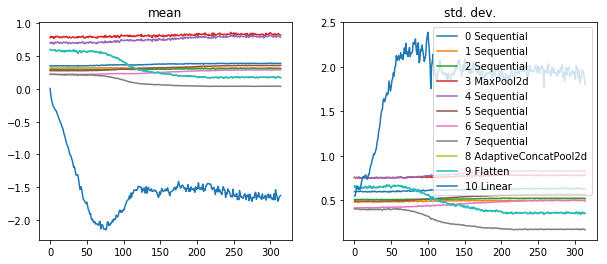

In [154]:
plot_hooks(hooks_freeze_non_bn,fig_name='freeze_non_bn_layers.png',model=learn.model)

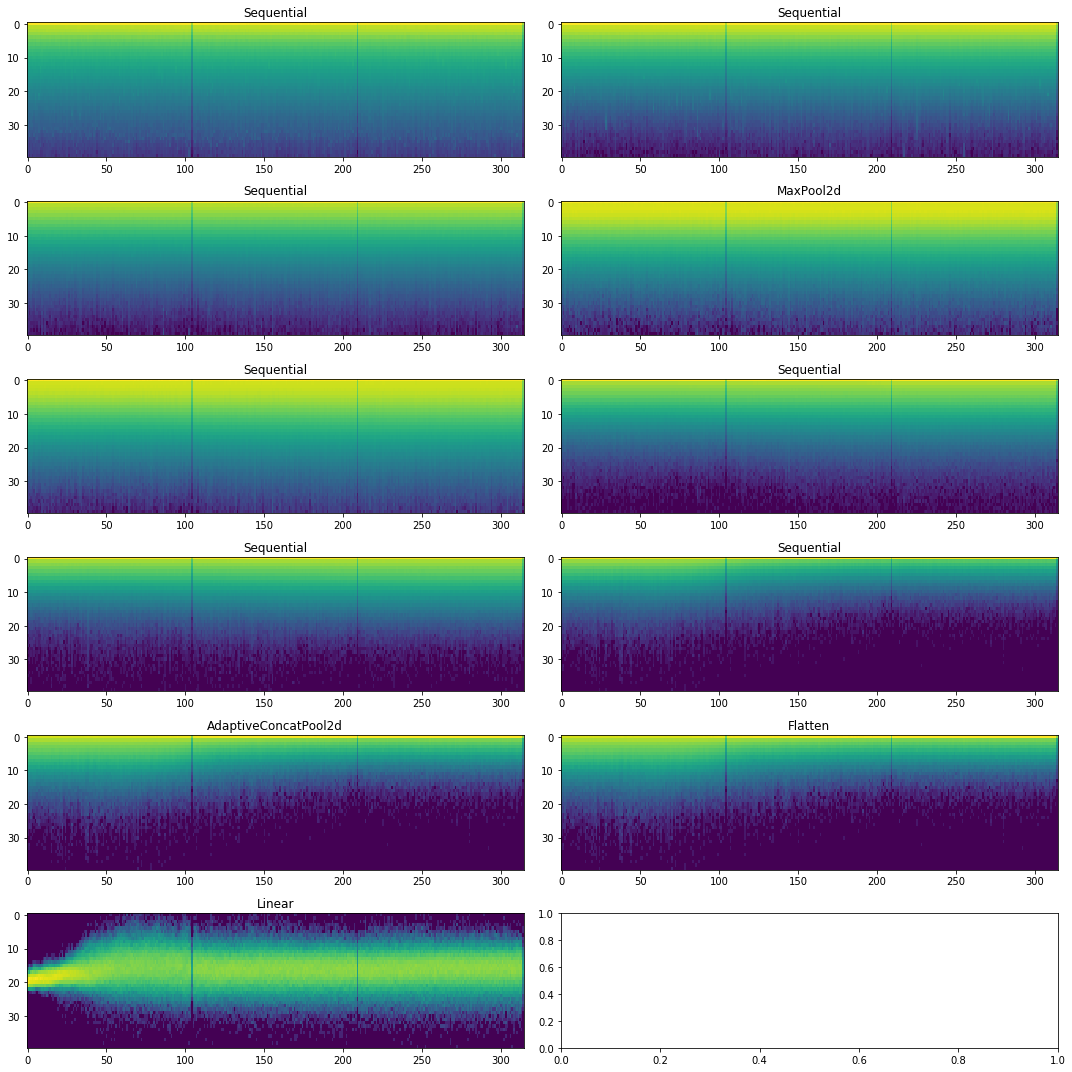

In [155]:
plot_hooks_hist(hooks_freeze_non_bn,fig_name='freeze_non_bn_hist.png',model=learn.model)

In [156]:
#plot_hooks_delta_hist(hooks_freeze_non_bn,fig_name='freeze_non_bn_delta_hist.png',model=learn.model)

In [157]:
#plot_mins(hooks_freeze_non_bn)

In [158]:
freeze_non_bn_del_ms,freeze_non_bn_del_sds=diff_stats(hooks_freeze_non_bn)

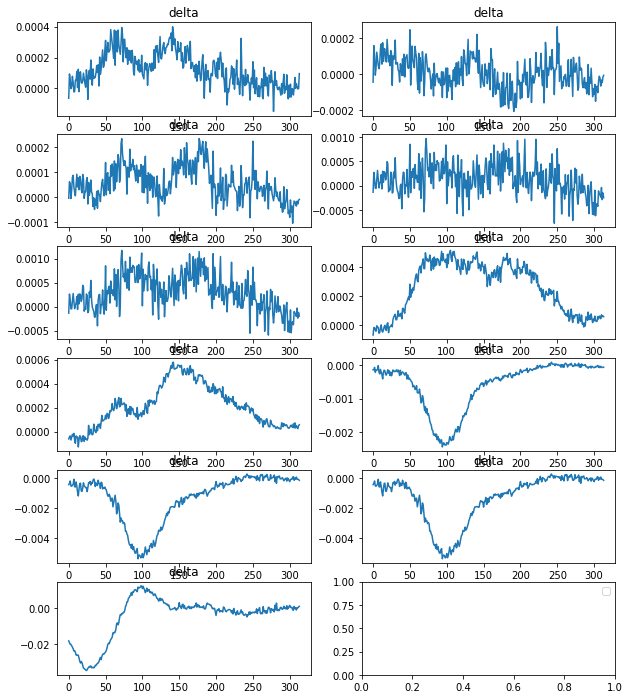

In [159]:
plot_deltas(freeze_non_bn_del_ms, 50,fig_name='freeze_non_bn_del_ms.png')

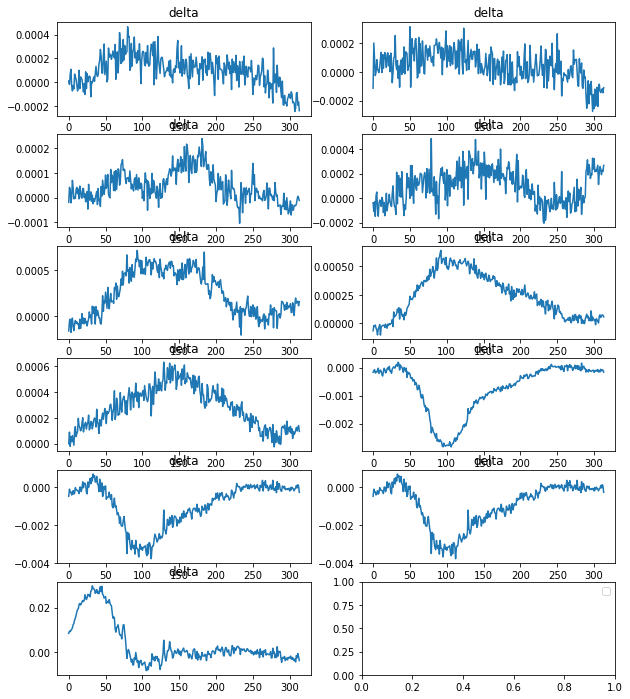

In [160]:
plot_deltas(freeze_non_bn_del_sds, 50,fig_name='freeze_non_bn_del_sds.png')

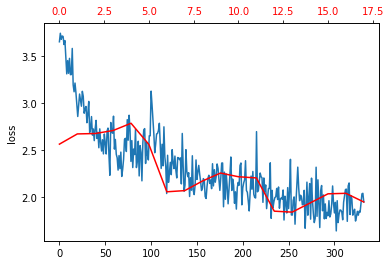

In [161]:
learn.recorder.plot_loss()

#### Unfreeze

In [162]:
#reset
stat_iter=0

In [163]:
INDEX_DICT={}
SHAPE_DICT={}
HOOK_DATA_PATH = HOOK_PATH/'bn_unfreeze'
HOOK_DATA_PATH.mkdir(exist_ok=True)

In [164]:
apply_mod(learn.model, partial(set_grad, b=True))

<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.container.Sequential'>
<class 'exp.nb_formatted.ResBlock'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'tor

In [165]:
with Hooks(learn.model, append_hist_stats_save) as hooks_unfreeze_non_bn: 
    learn.fit(5, cbsched, reset_opt=True)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/walle/miniconda3/envs/fastai-py3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/walle/miniconda3/envs/fastai-py3.7/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/walle/miniconda3/envs/fastai-py3.7/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/walle/miniconda3/envs/fastai-py3.7/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/walle/miniconda3/envs/fastai-py3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/walle/miniconda3/envs/fastai-py3.7/lib/python3.7/multiprocessing/connection.py", line

KeyboardInterrupt: 

In [ ]:
write_index_file(data=INDEX_DICT, file_name=HOOK_DATA_PATH/'index.txt')
write_index_file(data=SHAPE_DICT, file_name=HOOK_DATA_PATH/'shape.txt')
print(f"wrote {len(INDEX_DICT)} items to : {HOOK_DATA_PATH/'index.txt'}")

In [ ]:
plot_hooks(hooks_unfreeze_non_bn,fig_name='unfreeze_non_bn_layers.png',model=learn.model)

In [ ]:
plot_hooks_hist(hooks_unfreeze_non_bn,fig_name='unfreeze_non_bn_hist.png',model=learn.model)

In [ ]:
#plot_hooks_delta_hist(hooks_unfreeze_non_bn,fig_name='unfreeze_non_bn_delta_hist.png',model=learn.model)

In [ ]:
#plot_mins(hooks_unfreeze_non_bn)

In [ ]:
unfreeze_non_bn_del_ms,unfreeze_non_bn_del_sds=diff_stats(hooks_unfreeze_non_bn)

In [ ]:
plot_deltas(unfreeze_non_bn_del_ms, 50,fig_name='unfreeze_non_bn_del_ms.png')

In [ ]:
plot_deltas(unfreeze_non_bn_del_sds, 50,fig_name='unfreeze_non_bn_del_sds.png')

In [ ]:
learn.recorder.plot_loss()

Pytorch already has an `apply` method we can use:

In [ ]:
learn.model.apply(partial(set_grad, b=False));

Lesson 12 video: 1:29

## Discriminative LR and param groups

In [ ]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette)

In [ ]:
learn.model.load_state_dict(torch.load(mdl_path/'iw5'))


In [ ]:
len(learn.model)

In [ ]:
adapt_simple_model(learn, data)

In [ ]:
len(learn.model)

In [ ]:
def bn_splitter(m):
    def _bn_splitter(l, g1, g2):
        if isinstance(l, nn.BatchNorm2d): 
            g2 += l.parameters()
        elif hasattr(l, 'weight'): 
            g1 += l.parameters()
        for ll in l.children(): 
            _bn_splitter(ll, g1, g2)
        
    g1,g2 = [],[]
    _bn_splitter(m[0], g1, g2)
    
    g2 += m[1:].parameters()
    return g1,g2

In [ ]:
m = learn.model

In [ ]:
a,b = bn_splitter(m)

In [ ]:
len(a)

In [ ]:
len(list(m.parameters()))

In [ ]:
test_eq(len(a)+len(b), len(list(m.parameters())))

In [ ]:
Learner.ALL_CBS

In [ ]:
#export
from types import SimpleNamespace
cb_types = SimpleNamespace(**{o:o for o in Learner.ALL_CBS})

In [ ]:
cb_types.after_backward

In [ ]:
#export
class DebugCallback(Callback):
    _order = 999
    def __init__(self, cb_name, f=None): self.cb_name,self.f = cb_name,f
    def __call__(self, cb_name):
        if cb_name==self.cb_name:
            if self.f: self.f(self.run)
            else:      set_trace()

In [ ]:
#export
def sched_1cycle(lrs, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = [combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
                 for lr in lrs]
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

In [ ]:
disc_lr_sched = sched_1cycle([0,3e-2], 0.5)

In [ ]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func,
                    c_out=10, norm=norm_imagenette, splitter=bn_splitter)

learn.model.load_state_dict(torch.load(mdl_path/'iw5'))
adapt_model(learn, data)

In [ ]:
def _print_det(o): 
    print (len(o.opt.param_groups), o.opt.hypers)
    raise CancelTrainException()

learn.fit(1, disc_lr_sched + [DebugCallback(cb_types.after_batch, _print_det)])

In [ ]:
learn.fit(3, disc_lr_sched)

In [ ]:
disc_lr_sched = sched_1cycle([1e-3,1e-2], 0.3)

In [ ]:
learn.fit(1, disc_lr_sched)

## Export

In [ ]:
#!./notebook2script.py 11a_transfer_learning.ipynb